In [1]:
import pandas as pd
import re
from itertools import repeat
import itertools

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

matplotlib.rcParams['figure.figsize'] = [20, 5]

import matplotlib.patches as patches
import matplotlib.lines as lines

import numpy as np

In [2]:
import Bio

In [3]:
proteinlength = 380

In [4]:
## Can be downloaded from COSMIC
mutations_COSMIC_LI = pd.read_csv("/Users/davidshorthouse/Documents/Data/COSMIC/Large_intestine_COSMIC_mutations.csv")

/var/folders/vv/0521912d5_j4wpw2lwprbrzw0000gn/T/ipykernel_81266/3413348312.py:1: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  mutations_COSMIC_LI = pd.read_csv("/Users/davidshorthouse/Documents/Data/COSMIC/Large_intestine_COSMIC_mutations.csv")


In [5]:
mutations_COSMIC_LI_WNT5A = mutations_COSMIC_LI[mutations_COSMIC_LI["GENE_SYMBOL"] == "WNT5A"]

mutations_WNT5A_missense = mutations_COSMIC_LI_WNT5A[mutations_COSMIC_LI_WNT5A["MUTATION_DESCRIPTION"] == "missense_variant"]
unique = mutations_WNT5A_missense.drop_duplicates(subset= ["SAMPLE_NAME", "GENOMIC_MUTATION_ID"])

In [6]:
mutationlist = []
mutationlist_aa = []
for line in unique["MUTATION_AA"]:
    if line.startswith("p."):
        mutation = line.split("p.")[1]
        if mutation == "?":
            continue
        elif "*" in mutation:
            continue
        else:
            startaa = mutation[0]
            endaa = mutation[-1]
            if startaa == endaa:
                continue
            else:
                mutationlist_aa.append(mutation)
                mutantnumber = int(re.findall('\d+', mutation)[0])
                mutationlist.append(mutantnumber)

In [7]:
listsforarray = []
listsforarray.append(list(range(1, proteinlength+1)))
for item in mutationlist:
    if item > proteinlength:
        continue
    zerolist = [0] * proteinlength
    zerolist[item-1] = 1
    listsforarray.append(zerolist)
mutationdataframe = pd.DataFrame(listsforarray)
mutationdataframe.columns = mutationdataframe.iloc[0]
mutationdataframe = mutationdataframe.reindex(mutationdataframe.index.drop(0))

In [8]:
WNT5A_mutants = unique["MUTATION_AA"].tolist()


mutantlist = []
for item in WNT5A_mutants:
    line = item.rstrip()
    if line.startswith("p."):
        #print(line)
        after_p = line.split(".")[1]
        firstletter = after_p[:1].upper()
        lastletter = after_p[-1:].upper()
        if firstletter == "?":
            continue
        elif firstletter == lastletter:
            continue
        else:
            if "*" in line: 
                continue
                muttype = "FS"
                after_p = after_p.split("*")[0]
            else:
                muttype = "MS"
        mutation = (line.split(".")[1].split("*")[0])
        mutantnumber = (re.findall('\d+', after_p))
        for item in mutantnumber:
            mutantlist.append([item, mutation, muttype])
 

mutantdataframe = pd.DataFrame(mutantlist,columns=['Residue', 'Mutation','Type'])
count_series = mutantdataframe.groupby(['Residue', 'Type']).size()
mutation_frequencyframe = count_series.to_frame(name = 'Counts').reset_index()
mutation_frequencyframe = mutation_frequencyframe.sort_values("Counts", ascending = False)

mutation_max = max(mutation_frequencyframe["Counts"])

mutationcountlist = []
for residue, mutationtype in zip(mutation_frequencyframe["Residue"], mutation_frequencyframe["Type"]):
    for residue2, mutationtype2 in zip(mutantdataframe["Residue"], mutantdataframe["Type"]):
        if residue ==residue2:
            if mutationtype == mutationtype2:
                #print(residue2, mutationtype2)
                mutationframe = (mutantdataframe.loc[mutantdataframe["Residue"] == residue])
                mutationframe_type = mutationframe[mutationframe["Type"] == mutationtype]
                mutationlist = mutationframe_type["Mutation"].unique()
                mutationcountlist.append((mutationlist.tolist(), int(mutation_frequencyframe[mutation_frequencyframe["Type"]==mutationtype].loc[mutation_frequencyframe["Residue"] == residue]["Counts"].values[0]), mutationtype, residue))
                
                
processed_dataframe = pd.DataFrame(mutationcountlist,columns=['Mutations', 'Count', "Type", "Residue"])
processed_dataframe["Mutations"] = processed_dataframe["Mutations"].apply(lambda x: x[0] +"/"+ x[1][-1] if len(x) >1 else x[0])
processed_dataframe= processed_dataframe.drop_duplicates()

In [9]:
mutationlist = []
for index, columns in mutation_frequencyframe.iterrows():
    mutationlist.extend(repeat(int(columns["Residue"]), int(columns["Counts"])))
    
## Missense
x = range(1,proteinlength)
mutantcount = []
mutantcount_nozeroes = []
for i in x:
    if mutationlist.count(i) != 0:
        mutantcount.append(mutationlist.count(i))
        mutantcount_nozeroes.append(mutationlist.count(i))
    elif mutationlist.count(i) == 0:
        mutantcount.append(-1)

In [10]:
clusteringresults = pd.read_csv("./WNT5A_mutational_clusters.csv")

In [11]:
 clusteringresults

,Unnamed: 0,cluster_size,start,end,number,p_value
0,X310,13,310,322,10,0.000014
1,X310,4,310,313,6,0.000036
2,X310,2,310,311,5,0.000046
3,X183,2,183,184,5,0.000046
4,X310,1,310,310,4,0.000069
5,X184,1,184,184,4,0.000069


In [12]:
genecolour = sns.color_palette("Set2")[0]

def plotrec(x1, x2, y, name, color, height = 0.3):
    width = abs(x2-x1)
    axes.add_patch(patches.Rectangle([x1, y], width, height, lw = 2, facecolor = color, edgecolor = "k", zorder = 100, clip_on=False))
    axes.text(x1+(width/2),0, name, size = 14, clip_on=False, zorder= 101
              , horizontalalignment = "center", verticalalignment = "center", rotation = 0, weight = "bold")
    
def plotline(x1, x2, y, color):
    line = lines.Line2D([x1, x2], [y, y], lw = 3, color = color, axes = axes, clip_on=False, marker = "|", mew = 3)
    axes.add_line(line)

In [13]:
WNT_dict = {"THUMB": [228, 255, sns.color_palette("Set3")[2]]
             ,"FINGER": [348, 375, sns.color_palette("Set3")[10]]
            }

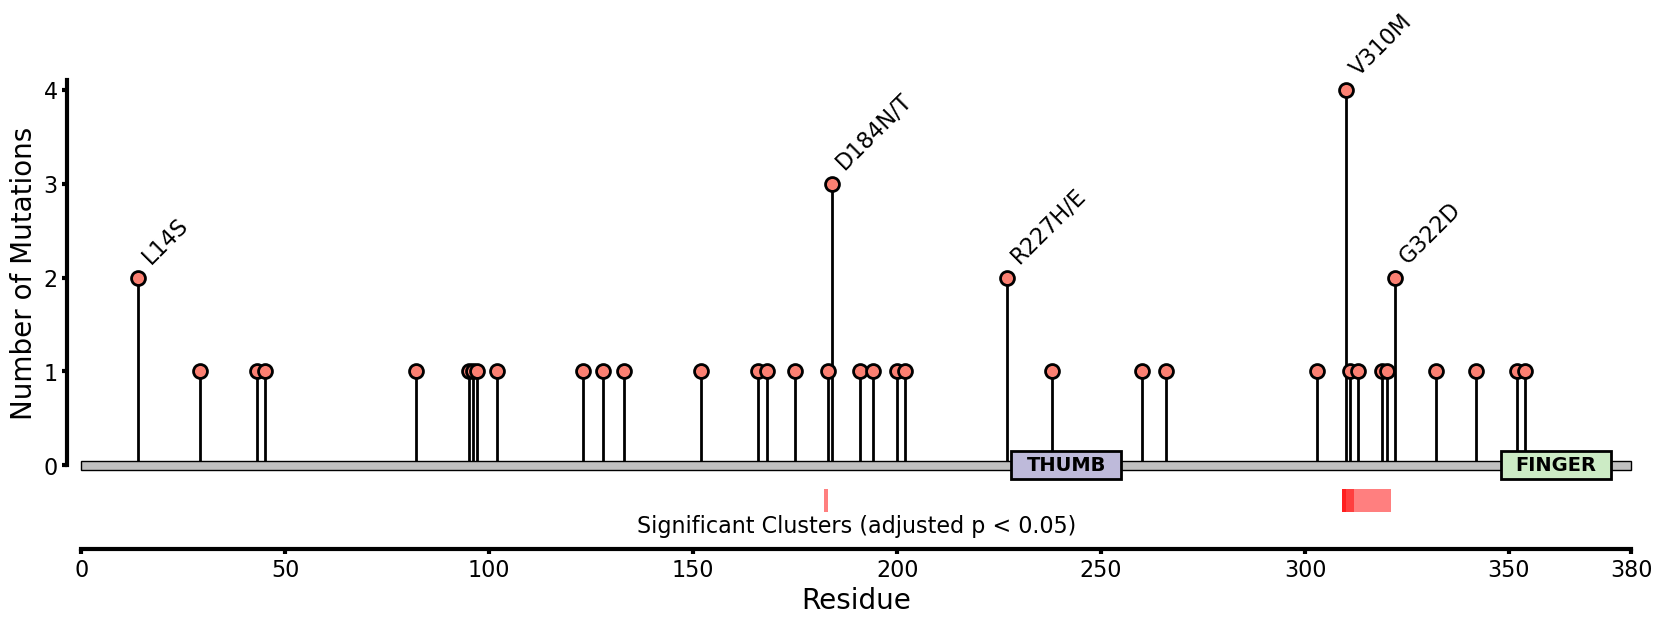

In [14]:
fig = plt.figure()
axes = fig.add_subplot(111)
#axes = plt.gca()
(markers, stemlines, baseline) = plt.stem(x, mutantcount)

sns.despine(offset = {"left":10, "bottom":60})
plt.setp(markers, markersize=10, markeredgecolor="k", markeredgewidth=2, c = sns.color_palette("Set3")[3], zorder = 10, clip_on=True)
plt.setp(baseline, linestyle="-", color="#C0C0C0", linewidth=6, zorder = 0.5, visible = False)
plt.setp(stemlines, linestyle="-", color="k", linewidth=2 , zorder = 5)

axes.set_ylim([0,4.1])
axes.set_xlim([0,proteinlength])


axes.set_yticks([0,1,2,3,4])
axes.set_xticks([0, 50, 100, 150, 200, 250, 300, 350, proteinlength])
plt.xticks(rotation = "horizontal", size = 16)
plt.yticks(rotation = "horizontal", size = 16)

for key, residues in WNT_dict.items():
        plotrec(residues[0],residues[1], -0.15, key, residues[2], 0.3)
axes.add_patch(patches.Rectangle([0, -0.05], proteinlength, 0.1, edgecolor = "k", facecolor = "#C0C0C0", zorder = 99, clip_on=False))

 
plt.ylabel("Number of Mutations", size = 20)
plt.xlabel("Residue", size =20)

for index, row in processed_dataframe.iterrows():
    if row["Count"] >= 2:
        axes.text(int(row["Residue"]), int(row["Count"])+0.1,row["Mutations"], horizontalalignment = "left", verticalalignment = "bottom", size = 16, zorder = 1001, rotation = 45)

#        axes.text(int(row["Residue"])-3, int(row["Count"])+0.1,row["Mutations"], horizontalalignment = "left", verticalalignment = "bottom", size = 16, zorder = 1001, rotation = 45)
        
        
plt.text(proteinlength/2, -0.65, "Significant Clusters (adjusted p < 0.05)", ha = "center", va = "center",
    clip_on = False, size = 16)      

for index2, row2 in itertools.islice(clusteringresults.iterrows(), 10):
    box = patches.Rectangle(((row2["start"]-1, -0.25)), ((row2["end"]-1))-((row2["start"]-1)), -0.25, linewidth=1, edgecolor='none', facecolor='red', clip_on = False, alpha = 0.5)
    axes.add_patch(box)

for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(3)
axes.tick_params(width=3)
plt.savefig("WNT5A_mutations_largeintestine.pdf", bbox_inches = "tight")
plt.show()



## Look at mutational energies

In [17]:
## Calculated using FoldX

WNT5A_energies = pd.read_csv("./PS_WNT5A_final_Repair_scanning_output.txt", sep = "\t",names = ["Mutation", "DDG"])

In [18]:
array_columns = []

for item in WNT5A_energies["Mutation"]:
    FromAA = item[:3]
    
    residue = int(item[4:-1])

    toAA = item[-1]
    array_columns.append([FromAA, residue, toAA])

In [19]:
WNT5A_energies[["FromAA", "Residue", "ToAA"]] = array_columns

In [20]:
WNT5A_energies = WNT5A_energies[WNT5A_energies["DDG"] <= 10]

In [21]:
WNT5A_energies

,Mutation,DDG,FromAA,Residue,ToAA
0,META1M,0.000000,MET,1,M
1,META1G,0.223748,MET,1,G
2,META1A,0.264048,MET,1,A
3,META1L,0.187802,MET,1,L
4,META1V,0.299088,MET,1,V
...,...,...,...,...,...
7975,LYSA380N,0.069711,LYS,380,N
7976,LYSA380W,1.118960,LYS,380,W
7977,LYSA380Y,-0.167289,LYS,380,Y
7978,LYSA380F,-0.351305,LYS,380,F


In [22]:
WNT5A_energies[WNT5A_energies["Residue"] == 315]

,Mutation,DDG,FromAA,Residue,ToAA
6594,THRA315T,0.000000e+00,THR,315,T
6595,THRA315G,9.950740e-01,THR,315,G
6596,THRA315A,3.823710e-01,THR,315,A
6597,THRA315L,-1.112090e+00,THR,315,L
6598,THRA315V,-2.197180e-01,THR,315,V
6599,THRA315I,-8.457840e-01,THR,315,I
6600,THRA315P,6.355600e-01,THR,315,P
6601,THRA315R,-2.126530e-01,THR,315,R
6602,THRA315T,2.273740e-13,THR,315,T
6603,THRA315S,-2.103440e-01,THR,315,S


In [23]:
WNT5A_energies["ToAA"] = WNT5A_energies['ToAA'].replace(['o', 'e'], 'H')

In [24]:
d = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
     'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
     'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
     'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M', 'H2S': 'H', 'H1S': "H"}

def shorten(x):
    if len(x) % 3 != 0: 
        raise ValueError('Input length should be a multiple of three')

    y = ''
    for i in range(len(x) // 3):
        y += d[x[3 * i : 3 * i + 3]]
    return y

In [25]:
basedist = WNT5A_energies[["Mutation", "DDG"]]
basedist["Dist"] = "base"

/var/folders/vv/0521912d5_j4wpw2lwprbrzw0000gn/T/ipykernel_81266/1174217728.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  basedist["Dist"] = "base"


In [26]:
shortAA = []

for item in WNT5A_energies["FromAA"]:
    shortAA.append(shorten(item))

In [27]:
WNT5A_energies["FromAA"] = shortAA
WNT5A_energies["mutation"] =WNT5A_energies["FromAA"] + WNT5A_energies["Residue"].astype(str) + WNT5A_energies["ToAA"]

In [28]:
coad_mutations = WNT5A_energies[WNT5A_energies["mutation"].isin(mutationlist_aa)]

In [29]:
hinge_mutations = coad_mutations[coad_mutations["Residue"] > 300]
hinge_mutations = hinge_mutations[hinge_mutations["Residue"] < 340]

In [30]:
hinge_mutations

,Mutation,DDG,FromAA,Residue,ToAA,mutation
6358,ASPA303N,1.137570,D,303,N,D303N
6500,VALA310M,0.290407,V,310,M,V310M
6530,ARGA311o,0.652826,R,311,H,R311H
6693,GLYA319D,8.729330,G,319,D,G319D
6710,THRA320M,0.063424,T,320,M,T320M
6756,GLYA322D,3.183890,G,322,D,G322D
6956,META332I,0.271159,M,332,I,M332I


In [31]:
coad_mutations  = coad_mutations[["Mutation", "DDG"]]
coad_mutations["Dist"] = "coad"

hinge_mutations  = hinge_mutations[["Mutation", "DDG"]]
hinge_mutations["Dist"] = "hinge"

/var/folders/vv/0521912d5_j4wpw2lwprbrzw0000gn/T/ipykernel_81266/3774996835.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hinge_mutations["Dist"] = "hinge"


In [34]:
import scipy.stats
scipy.stats.mannwhitneyu(basedist["DDG"], hinge_mutations["DDG"])

MannwhitneyuResult(statistic=22902.5, pvalue=0.5443109419603255)

In [35]:
#plottingframe = pd.concat([basedist, coad_mutations, hinge_mutations])

plottingframe = pd.concat([basedist, hinge_mutations])

/var/folders/vv/0521912d5_j4wpw2lwprbrzw0000gn/T/ipykernel_81266/1625802008.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.boxplot(y = plottingframe["DDG"], x = plottingframe["Dist"], palette= sns.color_palette("Set3"))
/var/folders/vv/0521912d5_j4wpw2lwprbrzw0000gn/T/ipykernel_81266/1625802008.py:4: UserWarning: The palette list has more values (12) than needed (2), which may not be intended.
  g = sns.boxplot(y = plottingframe["DDG"], x = plottingframe["Dist"], palette= sns.color_palette("Set3"))
/var/folders/vv/0521912d5_j4wpw2lwprbrzw0000gn/T/ipykernel_81266/1625802008.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_yticklabels([-4,-2,0,2,4,6,8,10, 12], size = 16)
/var/folders/vv/0521912d5_j4wpw2lwprbrzw0000gn/T/ipykernel_81266/1625802008.p

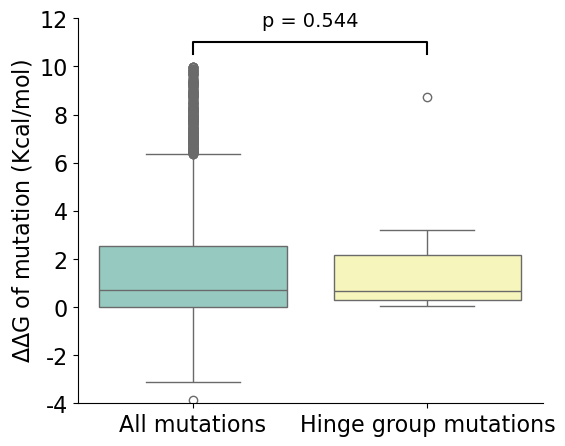

In [37]:
matplotlib.rcParams['figure.figsize'] = [6, 5]


g = sns.boxplot(y = plottingframe["DDG"], x = plottingframe["Dist"], palette= sns.color_palette("Set3"))

g.set_ylabel("$\\Delta\\Delta$G of mutation (Kcal/mol)", size = 16)
g.set_yticklabels([-4,-2,0,2,4,6,8,10, 12], size = 16)
g.set_xlabel("")

g.set_ylim(-4,12)

g.set_xticklabels(["All mutations", "Hinge group mutations"], size = 16)

# statistical annotation
x1, x2 = 0, 1   
y, h, col =  10.5, 0.5, 'k'

plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col, clip_on = False)
plt.text((x1+x2)*.5, 11.5, "p = 0.544", ha='center', va='bottom', color=col, size = 14)


sns.despine()

plt.savefig("Mutational_energies_WNT5A_hinge.pdf", bbox_inches = "tight")

/var/folders/vv/0521912d5_j4wpw2lwprbrzw0000gn/T/ipykernel_81266/1076991752.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(plottingframe[plottingframe["Dist"] == "base"]["DDG"])
/var/folders/vv/0521912d5_j4wpw2lwprbrzw0000gn/T/ipykernel_81266/1076991752.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751



<Axes: xlabel='DDG', ylabel='Density'>

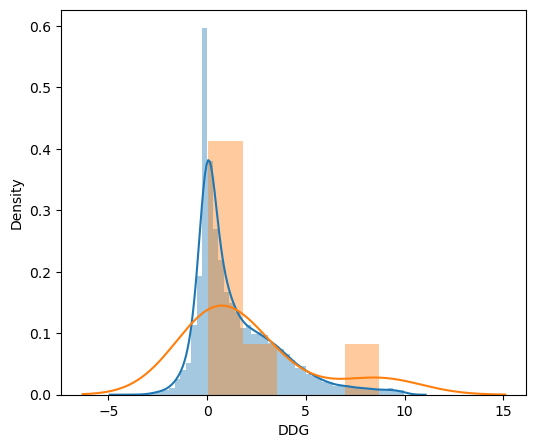

In [38]:
sns.distplot(plottingframe[plottingframe["Dist"] == "base"]["DDG"])

sns.distplot(plottingframe[plottingframe["Dist"] == "hinge"]["DDG"])

## Elastic Network Modelling

In [39]:
import prody

In [40]:
ubi = prody.parsePDB("./AF-P41221-F1-model_Repaired.pdb")
calphas = ubi.select('calpha and chain A')

@> 2953 atoms and 1 coordinate set(s) were parsed in 0.04s.


In [41]:
gnm = prody.GNM('WNT5A')
gnm.buildKirchhoff(calphas)

@> Kirchhoff was built in 0.02s.


In [42]:
gnm.calcModes()

@> 20 modes were calculated in 0.04s.


In [43]:
hinges = prody.calcHinges(gnm)

In [44]:
prody.calcHinges(gnm[0])

[41]

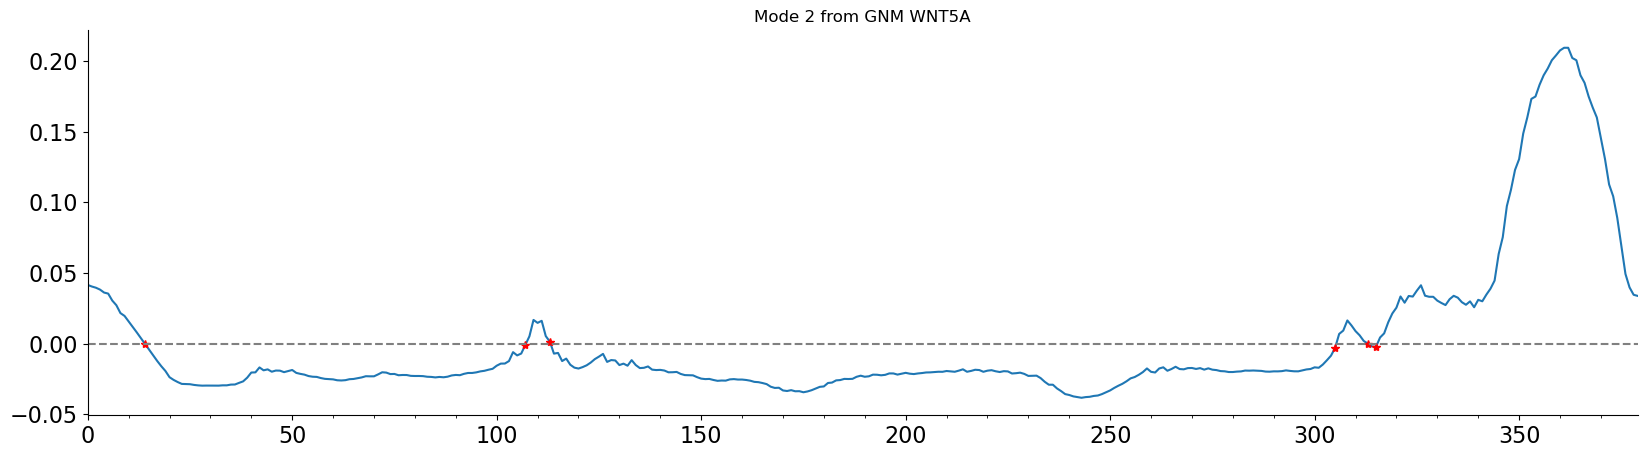

In [45]:
matplotlib.rcParams['figure.figsize'] = [20, 5]

g = prody.showMode(gnm[1], hinges=True, zero=True)

axes.set_ylim([-0.05, 0.2])
axes.set_xlim([0,proteinlength+2])


axes.set_yticks([0,1,2,3,4])
#axes.set_xticks([50, 100, 150, 200, 250, 300, 350, 340])
plt.xticks(rotation = "horizontal", size = 16)
plt.yticks(rotation = "horizontal", size = 16)

sns.despine()

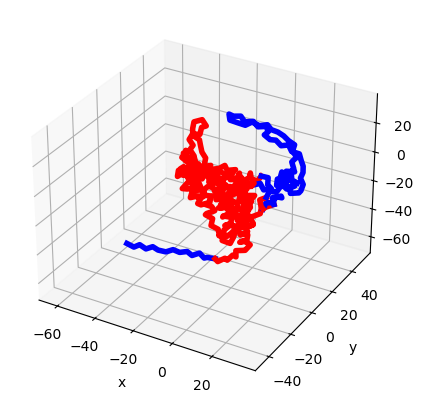

In [46]:
prody.showProtein(calphas, mode=gnm[1]);

In [47]:
second_mode = gnm[1]
second_mode_eigvec = second_mode.getEigvec().round(3)

gnm.calcModes()
hinges = gnm.calcModes

hingelist = prody.calcHinges(gnm[1])

scatter_values = []
for item in hingelist:
    scatter_values.append([item, second_mode_eigvec[item]])

@> 20 modes were calculated in 0.04s.


In [48]:
second_mode_eigvec_above =np.copy(second_mode_eigvec)
second_mode_eigvec_below = np.copy(second_mode_eigvec)

second_mode_eigvec_above[second_mode_eigvec_above < 0] = 0
second_mode_eigvec_below[second_mode_eigvec_below > 0] = 0

In [49]:
hingepoints = pd.DataFrame.from_records(scatter_values, columns= ["x", "y"])

In [50]:
hingepoints

,x,y
0,14,-0.000
1,107,-0.001
2,113,0.001
3,305,-0.003
4,313,-0.000
5,315,-0.002


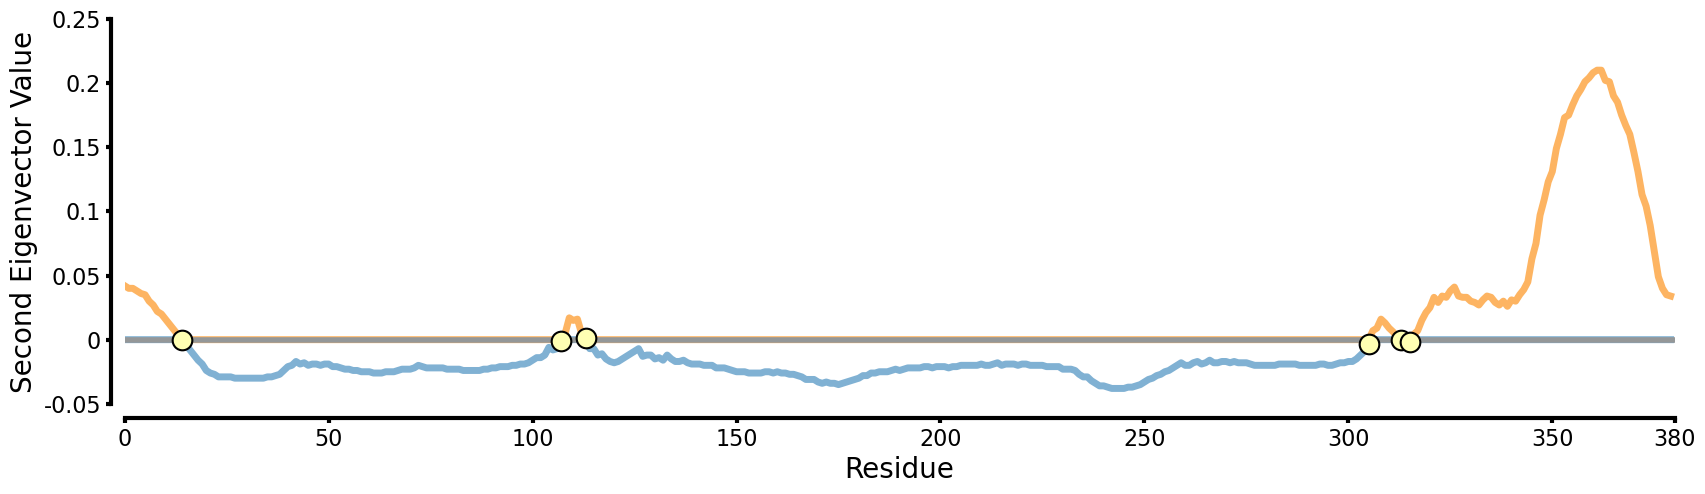

In [52]:
matplotlib.rcParams['figure.figsize'] = [20, 5]

ax2= sns.scatterplot(x = hingepoints["x"], y = hingepoints["y"], s= 200, zorder = 10, color = sns.color_palette("Set3")[1],linewidth = 1.5, edgecolor = "k")

sns.despine(offset = {"left":10, "bottom":10})

ax = sns.lineplot(data = second_mode_eigvec_above, lw = 5, color = sns.color_palette("Set3")[5])
ax = sns.lineplot(data = second_mode_eigvec_below, lw = 5, color = sns.color_palette("Set3")[4])
ax.set_xlim([0,380])
ax.set_xlabel("Residue", size =20)
ax.set_ylabel("Second Eigenvector Value", size = 20)
ax.set_ylim([-0.05, 0.25])
ax.set_yticks([-0.05, 0, 0.05, 0.1,0.15,0.2,0.25])
ax.set_yticklabels([-0.05, 0, 0.05, 0.10,0.15,0.20,0.25], size = 16)



ax.set_xticks([0,50, 100,150,200,250,300,350,380])
ax.set_xticklabels(ax.get_xticklabels(), size =16)
ax.axhline(0.0, c = "#949798", lw = 4
        )

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(3)
ax.tick_params(width=3)
sns.despine()

plt.savefig("Prody_dynamics.pdf", bbox_inches = "tight")